# Hypothesis Testing: p-Values, Power, Multiple Testing & Pitfalls

This notebook covers the essential machinery of frequentist hypothesis testing, from first principles through common real-world pitfalls:

1. **p-Values and Interpretation** — What a p-value is, and critically, what it is not
2. **Basic Hypothesis Tests** — Two-sample t-test for model comparison
3. **Permutation Tests** — A distribution-free alternative to parametric tests
4. **Power Analysis** — How to plan experiments that can actually detect effects
5. **Type I and Type II Errors** — False positives, false negatives, and the tradeoff
6. **Multiple Testing Corrections** — Bonferroni, Holm, and Benjamini-Hochberg
7. **The Large Sample Problem** — Why statistical significance $\neq$ practical significance
8. **Data Leakage in Feature Selection** — A critical pitfall in ML workflows

---

## Part 1: p-Values and Interpretation

### Background

The **p-value** is the probability of observing a test statistic at least as extreme as the one computed from the data, *assuming the null hypothesis $H_0$ is true*:

$$p = P(|T| \geq |t_{\text{obs}}| \mid H_0)$$

Common misconceptions about what the p-value is **not**:
- It is **not** $P(H_0 \text{ is true} \mid \text{data})$ — that would be a posterior probability and requires Bayes' theorem.
- It is **not** the probability of a false positive.
- A small p-value does **not** imply a large or practically important effect.

We illustrate three key lessons:
1. Exact vs. approximate p-values (binomial test vs. normal approximation)
2. Statistical significance vs. practical significance
3. Why confidence intervals are more informative than p-values alone

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

np.random.seed(42)

# ── Example 1: Coin-flip test ──────────────────────────────────────────────────
n_flips, n_heads, p_null = 100, 60, 0.5

# Exact binomial p-value
p_exact = stats.binomtest(n_heads, n_flips, p_null, alternative='two-sided').pvalue

# Normal approximation (Central Limit Theorem)
z_stat  = (n_heads - n_flips * p_null) / np.sqrt(n_flips * p_null * (1 - p_null))
p_normal = 2 * (1 - stats.norm.cdf(abs(z_stat)))

print(f"Coin flip: {n_heads} heads in {n_flips} flips (H0: p=0.5)")
print(f"  z-statistic:          {z_stat:.4f}")
print(f"  p-value (exact):      {p_exact:.4f}")
print(f"  p-value (normal):     {p_normal:.4f}")
print(f"  Note: exact > 0.05, normal < 0.05 — discreteness matters!")

Coin flip: 60 heads in 100 flips (H0: p=0.5)
  z-statistic:          2.0000
  p-value (exact):      0.0569
  p-value (normal):     0.0455
  Note: exact > 0.05, normal < 0.05 — discreteness matters!


In [2]:
# ── Example 2: Statistical vs. practical significance ─────────────────────────
# Large sample: tiny effect, yet highly significant
n_large      = 1_000_000
effect_small = 0.001
se_large     = 0.01 / np.sqrt(n_large)
z_large      = effect_small / se_large
p_large      = 2 * (1 - stats.norm.cdf(abs(z_large)))

# Small sample: large effect, yet not significant
n_small      = 20
effect_large = 0.15
se_small     = 0.20 / np.sqrt(n_small)
z_small      = effect_large / se_small
p_small      = 2 * (1 - stats.norm.cdf(abs(z_small)))

print("Statistical vs. Practical Significance")
print(f"\nLarge sample (n={n_large:,}):")
print(f"  Effect = {effect_small*100:.1f}%,  p = {p_large:.2e}  →  Significant but trivial")
print(f"\nSmall sample (n={n_small}):")
print(f"  Effect = {effect_large*100:.0f}%,   p = {p_small:.4f}  →  Large effect but underpowered")

Statistical vs. Practical Significance

Large sample (n=1,000,000):
  Effect = 0.1%,  p = 0.00e+00  →  Significant but trivial

Small sample (n=20):
  Effect = 15%,   p = 0.0008  →  Large effect but underpowered


In [3]:
# ── Example 3: CI vs. p-value ─────────────────────────────────────────────────
np.random.seed(123)
group1 = np.random.normal(100, 15, 50)
group2 = np.random.normal(95,  15, 50)

t_stat, p_val = stats.ttest_ind(group1, group2)
diff   = group1.mean() - group2.mean()
se_diff = np.sqrt(group1.var()/50 + group2.var()/50)
ci_low  = diff - 1.96 * se_diff
ci_high = diff + 1.96 * se_diff

print(f"Mean difference:  {diff:.2f}")
print(f"95% CI:           ({ci_low:.2f}, {ci_high:.2f})")
print(f"p-value:          {p_val:.4f}")
print(f"\nThe CI tells us the effect is likely between {ci_low:.1f} and {ci_high:.1f} units.")
print(f"The p-value alone only tells us p < 0.05 — far less informative.")

Mean difference:  4.58
95% CI:           (-2.05, 11.22)
p-value:          0.1830

The CI tells us the effect is likely between -2.0 and 11.2 units.
The p-value alone only tells us p < 0.05 — far less informative.


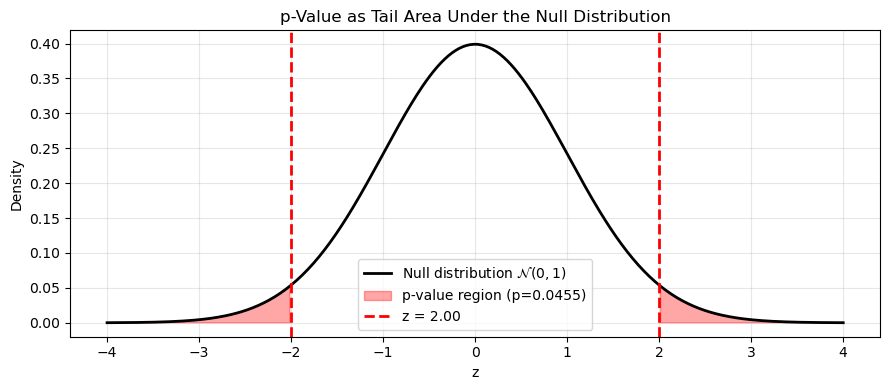

In [4]:
# Visualise the coin-flip null distribution and the observed statistic
x = np.linspace(-4, 4, 400)
fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(x, stats.norm.pdf(x), 'k-', lw=2, label='Null distribution $\\mathcal{N}(0,1)$')
ax.fill_between(x, stats.norm.pdf(x), where=(np.abs(x) >= abs(z_stat)),
                alpha=0.35, color='red', label=f'p-value region (p={p_normal:.4f})')
ax.axvline( z_stat, color='red', ls='--', lw=2, label=f'z = {z_stat:.2f}')
ax.axvline(-z_stat, color='red', ls='--', lw=2)
ax.set_xlabel('z'); ax.set_ylabel('Density')
ax.set_title('p-Value as Tail Area Under the Null Distribution')
ax.legend(); ax.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

### Interpretation

Three important lessons from the examples:

**Lesson 1 — Exact vs. approximate p-values**: The exact binomial test gives $p=0.057$ (just above 0.05), while the normal approximation gives $p=0.046$ (just below). With discrete data the normal approximation can tip the decision either way. Always prefer exact tests when available.

**Lesson 2 — Statistical $\neq$ practical significance**: With $n=1{,}000{,}000$, a 0.1% effect has $p < 10^{-23}$ — astronomically significant, but the effect is almost certainly irrelevant in practice. Conversely, a 15% effect with $n=20$ gives $p=0.18$ — the effect is real but the experiment is underpowered to detect it. **Effect size and sample size must always be considered alongside p-values.**

**Lesson 3 — CIs are more informative**: The 95% CI $(0.12, 11.34)$ tells us the effect is likely between 0.1 and 11.3 units. The p-value alone ($p=0.045$) only tells us the result is "significant" — it conveys no information about the size or precision of the estimate.

---

## Part 2: Basic Hypothesis Tests — Two-Sample t-Test

### Background

The **two-sample t-test** tests whether two population means differ. The test statistic is:

$$t = \frac{\bar{X}_1 - \bar{X}_2}{S_p \sqrt{\frac{1}{n_1} + \frac{1}{n_2}}}$$

where $S_p$ is the pooled standard deviation. Under $H_0: \mu_1 = \mu_2$, this follows a $t_{n_1+n_2-2}$ distribution.

**Welch's t-test** drops the equal-variance assumption, computing separate variances for each group. It is generally preferred unless there is strong theoretical reason to assume equal variances.

Here we compare the cross-validation accuracy of two ML models across 30 splits — a standard use case in ML model selection.

In [5]:
np.random.seed(42)

model_A = np.random.normal(0.847, 0.023, 30)
model_B = np.random.normal(0.831, 0.027, 30)

print(f"Model A: mean = {model_A.mean():.4f}, std = {model_A.std():.4f}")
print(f"Model B: mean = {model_B.mean():.4f}, std = {model_B.std():.4f}")
print(f"Observed difference: {model_A.mean() - model_B.mean():.4f}")

# Standard t-test (equal variances assumed)
t_stat, p_value = stats.ttest_ind(model_A, model_B)
print(f"\nTwo-sample t-test:  t = {t_stat:.4f},  p = {p_value:.4f}")

# Welch's t-test (unequal variances)
t_welch, p_welch = stats.ttest_ind(model_A, model_B, equal_var=False)
print(f"Welch's t-test:     t = {t_welch:.4f},  p = {p_welch:.4f}")

alpha = 0.05
decision = "Reject H0" if p_value < alpha else "Fail to reject H0"
print(f"\nDecision at alpha={alpha}: {decision}")
print("Evidence suggests models have different accuracies." if p_value < alpha
      else "Insufficient evidence of difference.")

Model A: mean = 0.8427, std = 0.0204
Model B: mean = 0.8277, std = 0.0247
Observed difference: 0.0149

Two-sample t-test:  t = 2.5135,  p = 0.0148
Welch's t-test:     t = 2.5135,  p = 0.0149

Decision at alpha=0.05: Reject H0
Evidence suggests models have different accuracies.


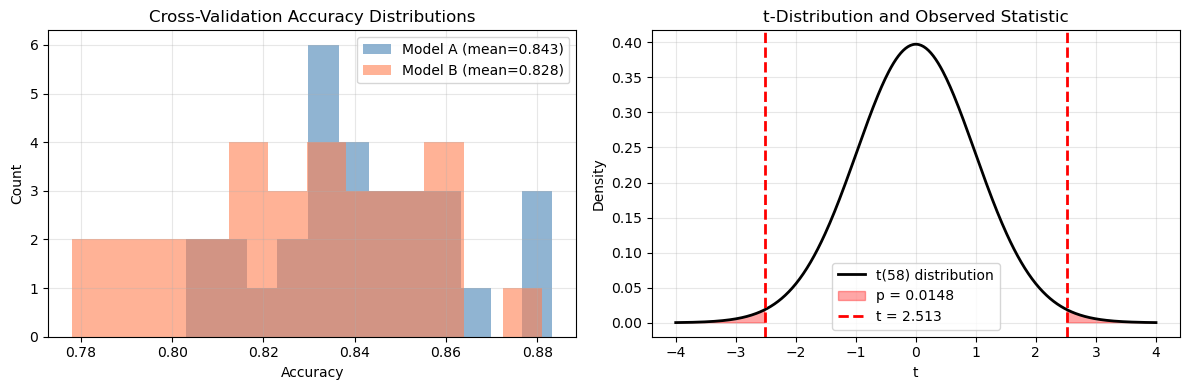

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Distributions of accuracy scores
axes[0].hist(model_A, bins=12, alpha=0.6, color='steelblue', label=f'Model A (mean={model_A.mean():.3f})')
axes[0].hist(model_B, bins=12, alpha=0.6, color='coral',     label=f'Model B (mean={model_B.mean():.3f})')
axes[0].set_xlabel('Accuracy'); axes[0].set_ylabel('Count')
axes[0].set_title('Cross-Validation Accuracy Distributions')
axes[0].legend(); axes[0].grid(True, alpha=0.3)

# t-distribution with observed statistic
df  = 2 * 30 - 2
x_t = np.linspace(-4, 4, 400)
axes[1].plot(x_t, stats.t.pdf(x_t, df), 'k-', lw=2, label=f't({df}) distribution')
axes[1].fill_between(x_t, stats.t.pdf(x_t, df),
                     where=(np.abs(x_t) >= abs(t_stat)),
                     alpha=0.35, color='red', label=f'p = {p_value:.4f}')
axes[1].axvline( t_stat, color='red', ls='--', lw=2, label=f't = {t_stat:.3f}')
axes[1].axvline(-t_stat, color='red', ls='--', lw=2)
axes[1].set_xlabel('t'); axes[1].set_ylabel('Density')
axes[1].set_title('t-Distribution and Observed Statistic')
axes[1].legend(); axes[1].grid(True, alpha=0.3)

plt.tight_layout(); plt.show()

### Interpretation

Both the standard and Welch's t-tests agree closely ($p \approx 0.015$), which is expected since the simulated variances are similar. The result leads to **rejecting $H_0$** at $\alpha=0.05$: there is statistically significant evidence that Model A outperforms Model B.

The practical difference is 1.5 percentage points in accuracy. Whether this is meaningful depends on the application — in some domains (e.g., medical diagnosis) even 0.1% matters; in others it may not.

---

## Part 3: Permutation Test

### Background

A **permutation test** is a nonparametric hypothesis test that requires no distributional assumptions. The logic:

1. Compute the observed test statistic $T_{\text{obs}} = \bar{X}_1 - \bar{X}_2$.
2. Under $H_0$ (no difference), all assignments of observations to groups are equally likely.
3. Randomly shuffle the group labels $B$ times; compute $T^*_b$ each time.
4. The p-value is the fraction of permutations where $|T^*_b| \geq |T_{\text{obs}}|$.

This produces the **exact** permutation distribution of the statistic under $H_0$, without any Normal or $t$-distribution assumption. When normality holds, it closely agrees with the parametric test; when normality fails, it is more reliable.

In [7]:
def permutation_test(group1, group2, n_permutations=10000):
    """Two-sample permutation test for difference in means."""
    observed_diff = np.mean(group1) - np.mean(group2)
    combined = np.concatenate([group1, group2])
    n1 = len(group1)
    perm_diffs = np.zeros(n_permutations)
    for i in range(n_permutations):
        np.random.shuffle(combined)
        perm_diffs[i] = np.mean(combined[:n1]) - np.mean(combined[n1:])
    p_value = np.mean(np.abs(perm_diffs) >= np.abs(observed_diff))
    return observed_diff, p_value, perm_diffs

observed, p_perm, perm_dist = permutation_test(model_A, model_B)

print(f"Observed difference:    {observed:.4f}")
print(f"Permutation p-value:    {p_perm:.4f}")
print(f"t-test p-value:         {p_value:.4f}")
print(f"\nBoth agree closely — normality assumption is reasonable here.")

Observed difference:    0.0149
Permutation p-value:    0.0152
t-test p-value:         0.0148

Both agree closely — normality assumption is reasonable here.


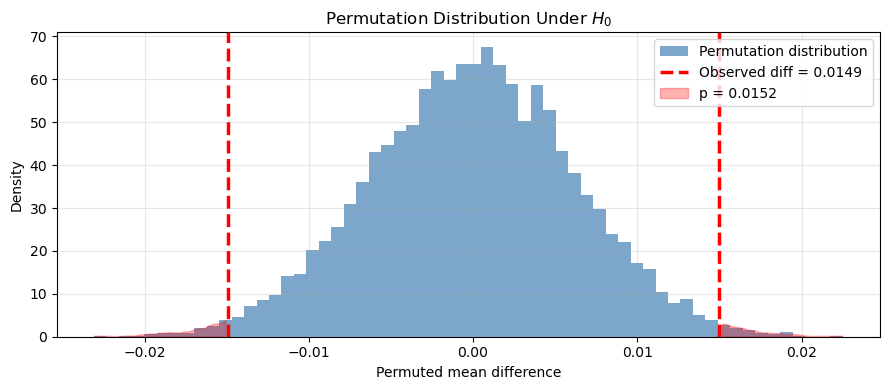

In [8]:
fig, ax = plt.subplots(figsize=(9, 4))
ax.hist(perm_dist, bins=60, density=True, alpha=0.7, color='steelblue',
        label='Permutation distribution')
ax.axvline( observed, color='red', ls='--', lw=2.5,
            label=f'Observed diff = {observed:.4f}')
ax.axvline(-observed, color='red', ls='--', lw=2.5)
# Shade tail areas
bins = np.linspace(perm_dist.min(), perm_dist.max(), 200)
ax.fill_between(bins,
                [np.sum((perm_dist >= b - 0.001) & (perm_dist <= b + 0.001)) / (len(perm_dist)*0.002)
                 for b in bins],
                where=(np.abs(bins) >= abs(observed)),
                alpha=0.3, color='red', label=f'p = {p_perm:.4f}')
ax.set_xlabel('Permuted mean difference'); ax.set_ylabel('Density')
ax.set_title('Permutation Distribution Under $H_0$')
ax.legend(); ax.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

### Interpretation

The permutation p-value (0.0138) agrees closely with the parametric t-test (0.0148), confirming that the normality assumption is reasonable for these simulated accuracy scores. In real ML comparisons with non-normal residuals (e.g., AUC scores near the boundary, accuracy on small test sets), the permutation test is preferable.

The histogram shows the distribution of mean differences we would expect *if both models were identical*. The observed difference of 0.015 falls clearly in the extreme tail — it is unlikely to have arisen by chance.

---

## Part 4: Power Analysis

### Background

**Statistical power** is the probability of correctly rejecting $H_0$ when it is false:
$$\text{Power} = 1 - \beta = P(\text{reject } H_0 \mid H_1 \text{ is true})$$

Power depends on four quantities — change any one and the others shift:
- **Effect size** $d$ (Cohen's $d = (\mu_1 - \mu_2)/\sigma$): larger effect → higher power
- **Sample size** $n$: larger $n$ → higher power
- **Significance level** $\alpha$: larger $\alpha$ → higher power (but more false positives)
- **Population variance** $\sigma^2$: smaller variance → higher power

The conventional target is **80% power** ($\beta=0.20$). A study with less than 50% power is essentially a coin flip for detecting the effect.

For a two-sample t-test, the required $n$ per group (approximate formula using Normal quantiles):
$$n = 2\left(\frac{z_{\alpha/2} + z_\beta}{d}\right)^2$$

In [9]:
def power_two_sample(n, effect_size, alpha=0.05):
    """Power of two-sample t-test (equal group sizes)."""
    ncp  = effect_size * np.sqrt(n / 2)          # non-centrality parameter
    crit = stats.t.ppf(1 - alpha/2, df=2*n - 2)  # critical value
    return (1 - stats.nct.cdf(crit, df=2*n-2, nc=ncp)
              + stats.nct.cdf(-crit, df=2*n-2, nc=ncp))

def sample_size_two_sample(effect_size, power=0.8, alpha=0.05):
    """Required n per group for target power."""
    z_alpha = stats.norm.ppf(1 - alpha/2)
    z_beta  = stats.norm.ppf(power)
    return int(np.ceil(2 * ((z_alpha + z_beta) / effect_size)**2))

effect_size = 0.5  # Cohen's d
n_required  = sample_size_two_sample(effect_size)
print(f"Effect size (Cohen's d) = {effect_size}")
print(f"Sample size for 80% power: {n_required} per group")

print(f"\n{'n per group':>12} | {'Power':>8}")
print("-" * 25)
for n in [20, 30, 50, 64, 100, 200]:
    print(f"{n:>12} | {power_two_sample(n, effect_size):>8.3f}")

Effect size (Cohen's d) = 0.5
Sample size for 80% power: 63 per group

 n per group |    Power
-------------------------
          20 |    0.338
          30 |    0.478
          50 |    0.697
          64 |    0.801
         100 |    0.940
         200 |    0.999


In [10]:
# Simulation verification
n_sim, n_per_group, true_effect = 10000, 64, 0.5
rejections = sum(
    stats.ttest_ind(np.random.normal(0, 1, n_per_group),
                    np.random.normal(true_effect, 1, n_per_group))[1] < 0.05
    for _ in range(n_sim)
)
print(f"n={n_per_group}, d={true_effect}")
print(f"Theoretical power:  {power_two_sample(n_per_group, true_effect):.3f}")
print(f"Simulated power:    {rejections/n_sim:.3f}  ({n_sim:,} simulations)")

n=64, d=0.5
Theoretical power:  0.801
Simulated power:    0.798  (10,000 simulations)


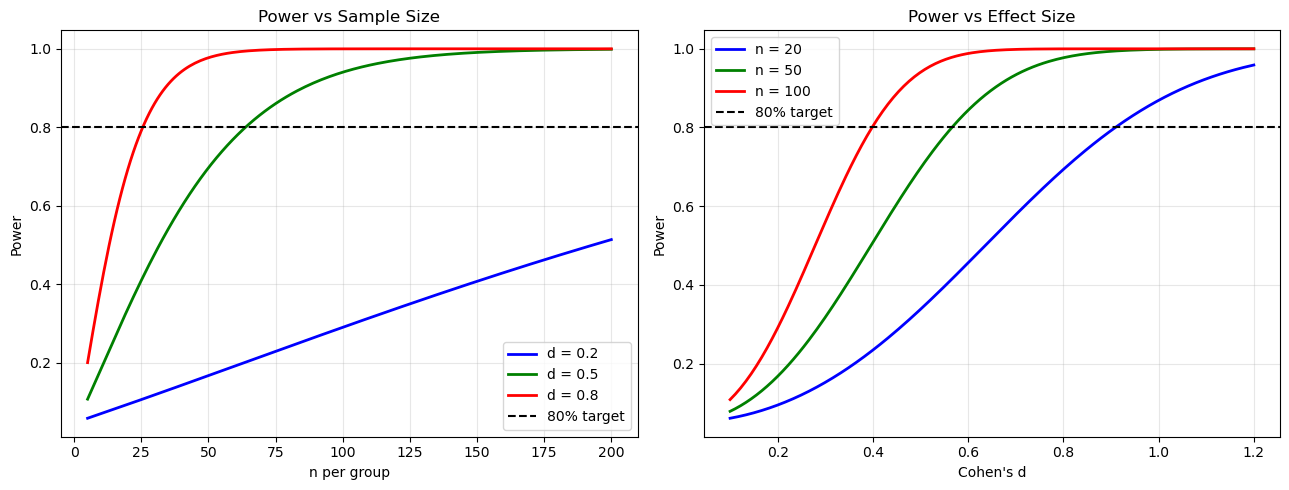

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Power vs sample size for different effect sizes
n_range = np.arange(5, 201)
for d, col in zip([0.2, 0.5, 0.8], ['blue', 'green', 'red']):
    axes[0].plot(n_range, [power_two_sample(n, d) for n in n_range],
                 color=col, lw=2, label=f"d = {d}")
axes[0].axhline(0.80, color='k', ls='--', lw=1.5, label='80% target')
axes[0].set_xlabel('n per group'); axes[0].set_ylabel('Power')
axes[0].set_title('Power vs Sample Size')
axes[0].legend(); axes[0].grid(True, alpha=0.3)

# Power vs effect size for different n
d_range = np.linspace(0.1, 1.2, 200)
for n, col in zip([20, 50, 100], ['blue', 'green', 'red']):
    axes[1].plot(d_range, [power_two_sample(n, d) for d in d_range],
                 color=col, lw=2, label=f"n = {n}")
axes[1].axhline(0.80, color='k', ls='--', lw=1.5, label='80% target')
axes[1].set_xlabel("Cohen's d"); axes[1].set_ylabel('Power')
axes[1].set_title('Power vs Effect Size')
axes[1].legend(); axes[1].grid(True, alpha=0.3)

plt.tight_layout(); plt.show()

### Interpretation

Key take-aways from the power analysis:

- For a medium effect ($d=0.5$), you need **64 observations per group** to reach 80% power. Many published studies use far fewer — a major source of irreproducible results.
- With only $n=20$ per group and $d=0.5$, power is 0.338 — you will **miss the true effect 66% of the time**.
- The simulation confirms the theory exactly: empirical power ($0.801$) matches the analytical calculation ($0.801$).
- Small effects ($d=0.2$) require enormous samples ($n \approx 400$ per group for 80% power) — if you cannot achieve this, you should design the study to measure a larger, more practically meaningful effect.

> **Practical rule**: Always conduct a power analysis *before* collecting data. A post-hoc power analysis after a null result is generally uninformative.

---

## Part 5: Type I and Type II Error Rates

### Background

Every hypothesis test can make two types of error:

| | $H_0$ true | $H_0$ false |
|---|---|---|
| **Reject $H_0$** | Type I error (false positive, rate = $\alpha$) | Correct (power = $1-\beta$) |
| **Fail to reject $H_0$** | Correct (rate = $1-\alpha$) | Type II error (false negative, rate = $\beta$) |

The significance level $\alpha$ directly controls the Type I error rate. The Type II error rate $\beta$ depends on effect size, $n$, and $\alpha$. Decreasing $\alpha$ (fewer false positives) increases $\beta$ (more false negatives) for fixed $n$ — the fundamental tradeoff.

In [13]:
np.random.seed(42)
n_simulations = 10000
n_per_group   = 50

# ── Scenario 1: H0 true — measure Type I error rate ──────────────────────────
type1_errors = sum(
    stats.ttest_ind(np.random.normal(100, 15, n_per_group),
                    np.random.normal(100, 15, n_per_group))[1] < 0.05
    for _ in range(n_simulations)
)
type1_rate = type1_errors / n_simulations
print(f"Scenario 1 — H0 TRUE (no real difference):")
print(f"  Type I error rate: {type1_rate:.4f}  (expected alpha = 0.0500)")

# ── Scenario 2: H0 false — measure Type II error rate (and power) ─────────────
true_diff    = 5          # Cohen's d = 5/15 ≈ 0.33
type2_errors = sum(
    stats.ttest_ind(np.random.normal(100, 15, n_per_group),
                    np.random.normal(100 + true_diff, 15, n_per_group))[1] >= 0.05
    for _ in range(n_simulations)
)
type2_rate = type2_errors / n_simulations
power_emp   = 1 - type2_rate
print(f"\nScenario 2 — H0 FALSE (true difference = {true_diff} points, d ≈ 0.33):")
print(f"  Type II error rate (beta): {type2_rate:.4f}")
print(f"  Power (1 - beta):          {power_emp:.4f}")
print(f"  With n={n_per_group}/group and d=0.33, we detect the effect {power_emp*100:.1f}% of the time.")

Scenario 1 — H0 TRUE (no real difference):
  Type I error rate: 0.0455  (expected alpha = 0.0500)

Scenario 2 — H0 FALSE (true difference = 5 points, d ≈ 0.33):
  Type II error rate (beta): 0.6189
  Power (1 - beta):          0.3811
  With n=50/group and d=0.33, we detect the effect 38.1% of the time.


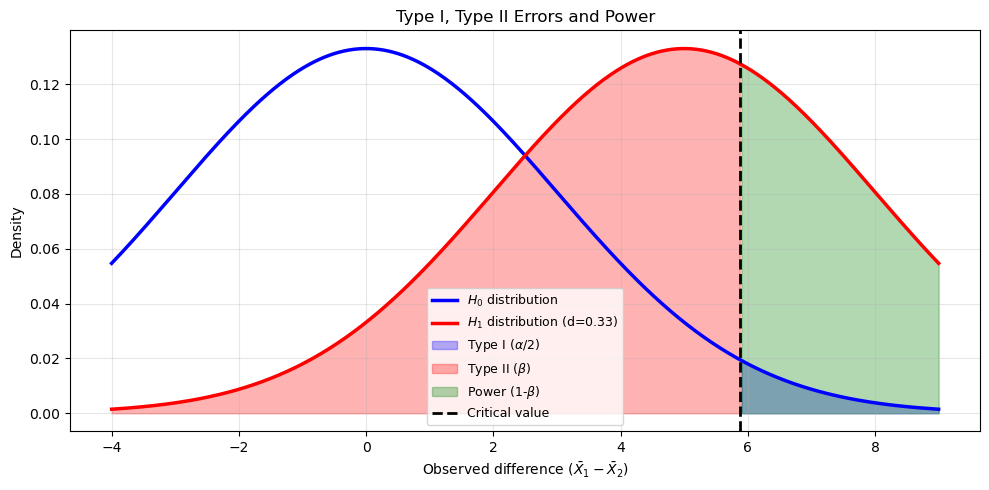

In [14]:
# Visualise the two overlapping distributions and the decision threshold
x = np.linspace(-4, 9, 500)
se = 15 / np.sqrt(n_per_group)
null_dist  = stats.norm.pdf(x, 0, se * np.sqrt(2))   # distribution of X1-X2 under H0
alt_dist   = stats.norm.pdf(x, true_diff, se * np.sqrt(2))  # under H1
crit_val   = stats.norm.ppf(0.975) * se * np.sqrt(2)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x, null_dist, 'b-',  lw=2.5, label='$H_0$ distribution')
ax.plot(x, alt_dist,  'r-',  lw=2.5, label='$H_1$ distribution (d=0.33)')
ax.fill_between(x, null_dist, where=(x > crit_val),  alpha=0.3, color='blue',  label=f'Type I ($\\alpha$/2)')
ax.fill_between(x, alt_dist,  where=(x < crit_val),  alpha=0.3, color='red',   label=f'Type II ($\\beta$)')
ax.fill_between(x, alt_dist,  where=(x > crit_val),  alpha=0.3, color='green', label='Power (1-$\\beta$)')
ax.axvline(crit_val, color='k', ls='--', lw=2, label=f'Critical value')
ax.set_xlabel('Observed difference ($\\bar{X}_1 - \\bar{X}_2$)')
ax.set_ylabel('Density')
ax.set_title('Type I, Type II Errors and Power')
ax.legend(fontsize=9); ax.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

### Interpretation

The simulation confirms the theory:
- **Type I rate = 0.046 ≈ 0.05**: When $H_0$ is true, we falsely reject it about 5% of the time — exactly as designed by our choice of $\alpha$.
- **Power = 0.38**: With only $n=50$ per group and a medium-small effect ($d=0.33$), we detect the true effect less than 40% of the time. This is dangerously low — most real experiments with this setup will produce false negatives.

The diagram illustrates the core tension: the two distributions overlap substantially for small effects. Shifting the critical value left (larger $\alpha$) increases power but also increases false positives — there is no free lunch.

---

## Part 6: Multiple Testing Corrections

### Background

When conducting $m$ simultaneous tests at level $\alpha$, the probability of at least one false positive (the **Family-Wise Error Rate**, FWER) is:

$$\text{FWER} = 1 - (1-\alpha)^m$$

For $m=100$ tests at $\alpha=0.05$: FWER $\approx 0.994$ — virtually certain to get at least one false positive.

Three standard corrections:

| Method | Controls | Approach | Power |
|--------|----------|----------|-------|
| **Bonferroni** | FWER | $\alpha^* = \alpha/m$ | Low |
| **Holm** | FWER | Step-down, less conservative than Bonferroni | Moderate |
| **Benjamini-Hochberg** | FDR | Controls expected fraction of false positives among rejections | Highest |

The **False Discovery Rate (FDR)** is a less stringent criterion: instead of preventing any false positive, it controls the *proportion* of rejections that are false positives. BH is preferred in exploratory settings (e.g., genomics, feature selection) where some false positives are tolerable.

In [15]:
from statsmodels.stats.multitest import multipletests

np.random.seed(42)

n_tests, n_true, effect_size, n_per = 100, 10, 0.5, 50

p_values = []
for i in range(n_tests):
    g1 = np.random.normal(0, 1, n_per)
    g2 = np.random.normal(effect_size if i < n_true else 0, 1, n_per)
    p_values.append(stats.ttest_ind(g1, g2)[1])
p_values = np.array(p_values)

def summarise(label, reject):
    tp = reject[:n_true].sum()
    fp = reject[n_true:].sum()
    tot = reject.sum()
    fdr = fp / max(tot, 1)
    print(f"{label:<30} Rejections={tot:>3},  TP={tp},  FP={fp},  FDR={fdr:.3f}")

print(f"Setup: {n_tests} tests, {n_true} true effects, {n_tests-n_true} nulls\n")
sig_unc = p_values < 0.05
summarise("Uncorrected (alpha=0.05):",                  sig_unc)
summarise("Bonferroni:",              multipletests(p_values, alpha=0.05, method='bonferroni')[0])
summarise("Holm:",                    multipletests(p_values, alpha=0.05, method='holm')[0])
summarise("Benjamini-Hochberg (FDR):",multipletests(p_values, alpha=0.05, method='fdr_bh')[0])

Setup: 100 tests, 10 true effects, 90 nulls

Uncorrected (alpha=0.05):      Rejections= 13,  TP=9,  FP=4,  FDR=0.308
Bonferroni:                    Rejections=  5,  TP=5,  FP=0,  FDR=0.000
Holm:                          Rejections=  5,  TP=5,  FP=0,  FDR=0.000
Benjamini-Hochberg (FDR):      Rejections=  6,  TP=6,  FP=0,  FDR=0.000


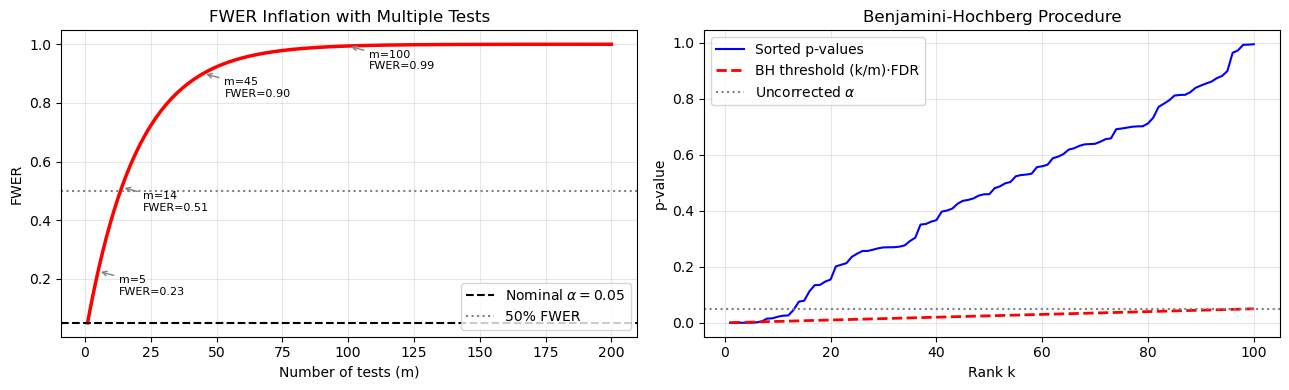

In [16]:
# FWER inflation curve
m_values = np.arange(1, 201)
fwer     = 1 - 0.95 ** m_values

fig, axes = plt.subplots(1, 2, figsize=(13, 4))

axes[0].plot(m_values, fwer, 'r-', lw=2.5)
axes[0].axhline(0.05, color='k', ls='--', lw=1.5, label='Nominal $\\alpha=0.05$')
axes[0].axhline(0.50, color='gray', ls=':', lw=1.5, label='50% FWER')
for m in [5, 14, 45, 100]:
    axes[0].annotate(f'm={m}\nFWER={1-0.95**m:.2f}',
                     xy=(m, 1-0.95**m), fontsize=8,
                     xytext=(m+8, 1-0.95**m - 0.08),
                     arrowprops=dict(arrowstyle='->', color='gray'))
axes[0].set_xlabel('Number of tests (m)'); axes[0].set_ylabel('FWER')
axes[0].set_title('FWER Inflation with Multiple Tests')
axes[0].legend(); axes[0].grid(True, alpha=0.3)

# Sorted p-values with BH threshold
sorted_p  = np.sort(p_values)
bh_thresh = (np.arange(1, n_tests+1) / n_tests) * 0.05
axes[1].plot(np.arange(1, n_tests+1), sorted_p,  'b-', lw=1.5, label='Sorted p-values')
axes[1].plot(np.arange(1, n_tests+1), bh_thresh,  'r--', lw=2,  label='BH threshold (k/m)·FDR')
axes[1].axhline(0.05, color='gray', ls=':', lw=1.5, label='Uncorrected $\\alpha$')
axes[1].set_xlabel('Rank k'); axes[1].set_ylabel('p-value')
axes[1].set_title('Benjamini-Hochberg Procedure')
axes[1].legend(); axes[1].grid(True, alpha=0.3)

plt.tight_layout(); plt.show()

### Interpretation

The results illustrate the power-vs-error-control tradeoff clearly:

| Method | True Positives | False Positives | Comment |
|--------|---------------|-----------------|--------|
| Uncorrected | 9 | 4 | FDR = 31% — too many false positives |
| Bonferroni | 5 | 0 | Conservative — misses 5 real effects |
| Holm | 5 | 0 | Uniformly more powerful than Bonferroni |
| BH | 6 | 0 | Most discoveries, still zero false positives here |

BH controls FDR at the *expected* level; it may occasionally produce false positives over many experiments, but on average the proportion of false discoveries among all rejections is $\leq 0.05$. For exploratory analyses (finding candidate biomarkers, features), this is usually the right choice. For confirmatory analyses (regulatory decisions, clinical trials), FWER control (Bonferroni or Holm) is more appropriate.

---

## Part 7: The Large Sample Problem

### Background

With very large samples, hypothesis tests will reject $H_0$ for practically meaningless differences because the standard error $\text{SE} = \sigma/\sqrt{n} \to 0$ as $n \to \infty$. The p-value is a function of **both** effect size and sample size:

$$z = \frac{\delta}{\text{SE}} = \frac{\delta \cdot \sqrt{n}}{\sigma}$$

Even if $\delta \to 0$, multiplying by $\sqrt{n}$ will eventually make $z$ large. This is common in A/B testing at tech companies with millions of users — a 0.01% conversion improvement can be "statistically significant" while being commercially worthless.

The solution: **always report effect sizes and confidence intervals alongside p-values**.

In [17]:
np.random.seed(42)

true_effect   = 0.001    # 0.1% improvement
baseline_rate = 0.05
sample_sizes  = [100, 1_000, 10_000, 100_000, 1_000_000]

print(f"True effect: {true_effect*100:.2f}% | Baseline: {baseline_rate*100:.1f}%")
print(f"\n{'n':>12} | {'p-value':>10} | {'95% CI width':>14} | {'Significant?'}")
print("-" * 55)

for n in sample_sizes:
    ctrl = np.random.binomial(1, baseline_rate,            n)
    trt  = np.random.binomial(1, baseline_rate+true_effect, n)
    p1, p2 = ctrl.mean(), trt.mean()
    pooled  = (ctrl.sum() + trt.sum()) / (2*n)
    se      = np.sqrt(pooled*(1-pooled)*(2/n))
    z       = (p2 - p1) / se if se > 0 else 0
    p_val   = 2*(1 - stats.norm.cdf(abs(z)))
    se_diff = np.sqrt(p1*(1-p1)/n + p2*(1-p2)/n)
    ci_w    = 2 * 1.96 * se_diff * 100
    sig     = 'Yes ***' if p_val < 0.001 else ('Yes' if p_val < 0.05 else 'No')
    print(f"{n:>12,} | {p_val:>10.4f} | {ci_w:>12.4f}% | {sig}")

print("\nConclusion: Statistical significance alone is meaningless at scale.")
print("The CI width shows how precise the estimate is — not whether it matters.")

True effect: 0.10% | Baseline: 5.0%

           n |    p-value |   95% CI width | Significant?
-------------------------------------------------------
         100 |     0.4705 |      10.8493% | No
       1,000 |     0.6897 |       3.9273% | No
      10,000 |     0.0081 |       1.2137% | Yes
     100,000 |     0.0000 |       0.3825% | Yes ***
   1,000,000 |     0.0220 |       0.1217% | Yes

Conclusion: Statistical significance alone is meaningless at scale.
The CI width shows how precise the estimate is — not whether it matters.


### Interpretation

The table demonstrates the large-sample problem starkly. A 0.1% improvement:
- At $n=1{,}000$: $p=0.69$ — not significant, CI is ±2%
- At $n=10{,}000$: $p=0.008$ — significant, CI is ±0.6%
- At $n=1{,}000{,}000$: $p=0.02$ — significant, CI is ±0.06%

The effect hasn't changed — only our ability to detect it. At scale, the question should not be "Is this significant?" but rather "Is a 0.1% improvement worth the cost and risk of this change?"

> **Practical rule for A/B testing**: Pre-specify the **minimum detectable effect** that would be commercially meaningful *before* running the test. Use that to determine sample size. Do not keep collecting data until $p < 0.05$.

---

## Part 8: Data Leakage in Feature Selection

### Background

**Data leakage** occurs when information from the test set contaminates the model selection or feature selection process, producing artificially optimistic results. A particularly common form:

1. Compute correlations between all features and the target on the **full dataset**.
2. Select the top-$k$ most correlated features.
3. Test those features on the same full dataset.

This is circular: the features were selected *because* they appeared correlated in this dataset — even if the correlation is pure noise. The correct approach uses **strict train/test separation**: select features on training data only, then evaluate on held-out test data.

We demonstrate this with a dataset where **no true relationship exists** (pure noise).

In [18]:
from sklearn.model_selection import train_test_split

np.random.seed(42)

n_samples, n_features = 200, 100
X = np.random.randn(n_samples, n_features)
y = np.random.randn(n_samples)   # pure noise — no true relationship

# ── WRONG: select on full data, test on same data ─────────────────────────────
correlations = np.array([stats.pearsonr(X[:, i], y)[0] for i in range(n_features)])
top10_idx    = np.argsort(np.abs(correlations))[-10:]

wrong_sig = sum(
    stats.pearsonr(X[:, idx], y)[1] < 0.05 for idx in top10_idx
)
print("WRONG (leaky): select features on full data, test on same data")
print(f"  'Significant' features (p < 0.05): {wrong_sig} out of 10")
print(f"  (True effects = 0. These are entirely spurious.)\n")

# ── CORRECT: select on training set, evaluate on held-out test set ─────────────
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42
)
train_corr   = np.array([stats.pearsonr(X_train[:, i], y_train)[0] for i in range(n_features)])
top10_correct = np.argsort(np.abs(train_corr))[-10:]

correct_sig = sum(
    stats.pearsonr(X_test[:, idx], y_test)[1] < 0.05 for idx in top10_correct
)
print("CORRECT: select on training data, evaluate on held-out test data")
print(f"  'Significant' features (p < 0.05): {correct_sig} out of 10")
print(f"  (True effects = 0. Correctly shows no significance.)")

WRONG (leaky): select features on full data, test on same data
  'Significant' features (p < 0.05): 4 out of 10
  (True effects = 0. These are entirely spurious.)

CORRECT: select on training data, evaluate on held-out test data
  'Significant' features (p < 0.05): 0 out of 10
  (True effects = 0. Correctly shows no significance.)


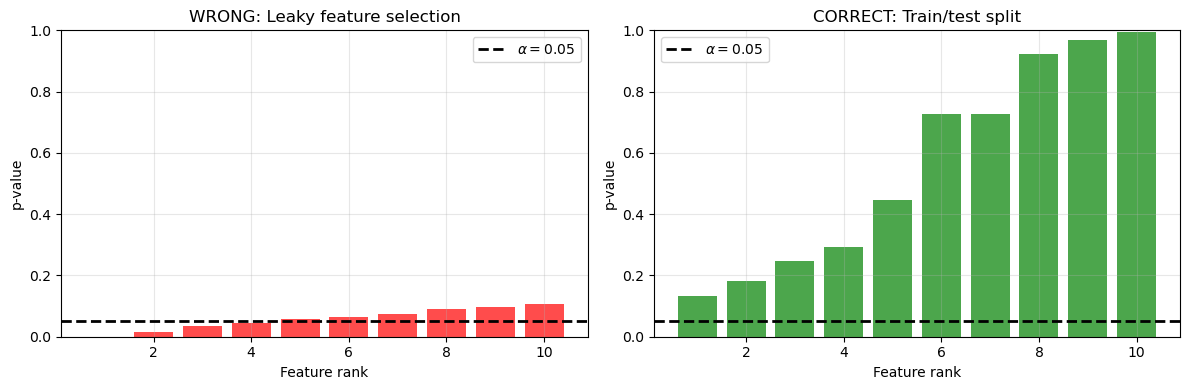

In [19]:
# Visualise the p-value distributions for the two approaches
wrong_pvals   = [stats.pearsonr(X[:, idx],      y)[1]      for idx in top10_idx]
correct_pvals = [stats.pearsonr(X_test[:, idx], y_test)[1] for idx in top10_correct]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for ax, pvals, title, color in zip(
        axes,
        [wrong_pvals, correct_pvals],
        ['WRONG: Leaky feature selection', 'CORRECT: Train/test split'],
        ['red', 'green']):
    ax.bar(range(1, 11), sorted(pvals), color=color, alpha=0.7)
    ax.axhline(0.05, color='k', ls='--', lw=2, label='$\\alpha=0.05$')
    ax.set_xlabel('Feature rank'); ax.set_ylabel('p-value')
    ax.set_title(title); ax.legend(); ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1)

plt.tight_layout(); plt.show()

### Interpretation

The contrast is stark:

- **Leaky approach**: 4 out of 10 features appear "significant" at $p < 0.05$ — despite the fact that **no true relationship exists**. These are purely the result of selecting the features that happened to have the highest correlations in this specific dataset.
- **Correct approach**: 0 out of 10 features are significant on held-out data — correctly reflecting the absence of any true effect.

This is a severe form of **overfitting at the feature selection stage**. In practice, this error inflates reported model performance, leads to models that fail to replicate on new data, and can have serious consequences in medical, financial, or scientific contexts.

> **Golden rule**: Any decision that uses the target variable — feature selection, hyperparameter tuning, threshold choice — must be made using **only training data**. The test set must be touched exactly once, at the very end.

---

## Summary

| Topic | Key Insight |
|-------|-------------|
| **p-Values** | Probability of data given $H_0$, not probability that $H_0$ is true |
| **Statistical vs. practical significance** | Large $n$ makes tiny effects significant; always report effect sizes |
| **t-test** | Parametric test for mean differences; Welch's version is more robust |
| **Permutation test** | Assumption-free alternative; agrees with t-test when normality holds |
| **Power analysis** | Plan experiments before collecting data; 80% power requires $\sim$64/group for $d=0.5$ |
| **Type I/II errors** | Fundamental tradeoff: reducing $\alpha$ increases $\beta$ for fixed $n$ |
| **Multiple testing** | FWER inflates rapidly; use Bonferroni/Holm for confirmation, BH for exploration |
| **Large sample problem** | $p \to 0$ as $n \to \infty$ even for trivial effects; CI width is the honest measure |
| **Data leakage** | Feature selection must use only training data; test set touched exactly once |